# Week 5

In [1]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice, angular_error
from utils.denoising import denoise_images
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms,text_removal
from utils.image_processing import calculate_histograms, text_removal, calculate_hog, calculate_lbp, calculate_orb, calculate_sift
from utils.segbackground import NMS, background_crop,iou_score
# 3rd Party Libraries
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.restoration import estimate_sigma
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from typing import Tuple, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import ml_metrics as metrics
import cv2
import os
import pickle
import math

In [2]:
def readimg (path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def estimate_noise(img):
    return estimate_sigma(img, multichannel=True, average_sigmas=True)

# Load Data

In [3]:
# Load Data
data_manager = DataManager()
db, db_files = data_manager.load_data(folder = "./data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")

qsd1_w5, qsd1_w5_files = data_manager.load_data(folder = "./data/qsd1_w5/", extension = ".jpg", desc = "Loading qsd1_w5 Data...")
qst1_w5, qst1_w5_files = data_manager.load_data(folder = "./data/qst1_w5/", extension = ".jpg", desc = "Loading qst1_w5 Data...")

Loading BBDD Data...: 100%|██████████| 287/287 [00:06<00:00, 41.84it/s]


./data/BBDD/ read: 287 images


Loading qsd1_w5 Data...: 100%|██████████| 30/30 [00:00<00:00, 157.75it/s]


./data/qsd1_w5/ read: 30 images


Loading qst1_w5 Data...: 100%|██████████| 50/50 [00:01<00:00, 47.89it/s]


./data/qst1_w5/ read: 50 images


This week we use mainly:
- QSD1-W4 (30) / QST1-W4 (50)  pictures with background, with overlapping text (name of painter), one, two or three paintings per image, some paintings with noise, some paintings with changes in color, some paintings not in database

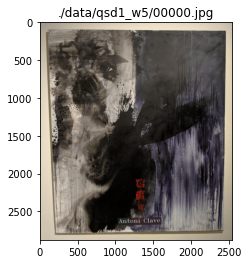

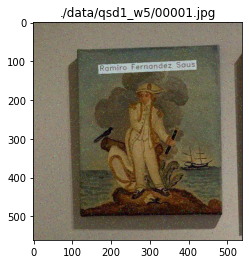

In [4]:
for img, filename in zip(qsd1_w5[:2], qsd1_w5_files[:2]):
    plt.imshow(img)
    plt.title(filename)
    plt.show()

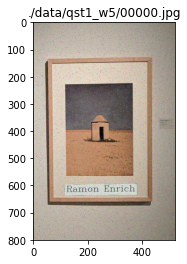

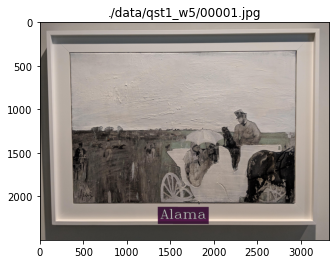

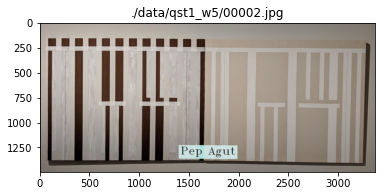

In [5]:
for img, filename in zip(qst1_w5[:3], qst1_w5_files[:3]):
    plt.imshow(img)
    plt.title(filename)
    plt.show()

## Preprocessing: Noise Reduction

In [6]:
DENOISE = True

if DENOISE: 
    qsd1_w5 = denoise_images(qsd1_w5, method='nlmeans', ksize=(3,3))
    qst1_w5 = denoise_images(qst1_w5, method='nlmeans', ksize=(3,3))

100%|██████████| 50/50 [04:10<00:00,  5.00s/it]


## Step 1) Crop, Angular correction, background removal and obtain the pictures.

In [7]:
with open("data/qsd1_w5/gt_corresps.pkl", 'rb') as f:
    gt_data = pickle.load(f)

with open('data/qsd1_w5/frames.pkl', 'rb') as f:
    frames = pickle.load(f)

In [8]:
gt_data[:5] ,frames[:5]

([[-1], [48], [260], [21], [128]],
 [[[1.1293404160637124, [[408, 180], [2752, 196], [2720, 2832], [488, 2876]]]],
  [[0.9495668564358084, [[298, 188], [660, 170], [672, 608], [310, 614]]]],
  [[0.8092086141573418,
    [[2220, 652], [3660, 632], [3660, 2652], [2244, 2672]]]],
  [[0.47945139879658427, [[128, 264], [621, 243], [643, 974], [165, 978]]]],
  [[179.72051060945523, [[756, 246], [1152, 236], [1168, 824], [758, 822]]]]])

In [9]:
def rotate_image(img, plot=False):
    
    bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(bw, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, math.pi / 180.0, 100, minLineLength=50, maxLineGap=8)

    angles = []
    
    if (lines is not None):
        for [[x1, y1, x2, y2]] in lines:
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            if angle < 30 and angle > -30:
                angles.append(angle)

    if len(angles) == 0:
        final_angle = 0.0
    else:
        final_angle = np.median(angles)
        
    #print (final_angle)
    img_rotated = ndimage.rotate(img, final_angle, mode='nearest')
    
    if plot:
        f, axarr = plt.subplots(1,3, figsize=(10,10))
        axarr[0].imshow(img)
        axarr[0].title.set_text("Original")
        axarr[0].axis('off')

        axarr[1].imshow(edges, cmap="gray")
        axarr[1].title.set_text(f"Canny Edges")
        axarr[1].axis('off')
        
        img_lines = img.copy()
        if (lines is not None) and (len(angles) != 0):
            for j in range(0, len(lines)):
                l = lines[j][0]
                cv2.line(img_lines, (l[0], l[1]), (l[2], l[3]), (0,255,0), 15, cv2.LINE_AA)
            
        axarr[2].imshow(img_lines, cmap="gray")
        axarr[2].title.set_text(f"Hough Lines")
        axarr[2].axis('off')
        
        plt.show()
        
    rot_angle = final_angle
    final_angle += 90
    #if final_angle<0: final_angle = final_angle + 360

    return img_rotated, np.round(final_angle,5), rot_angle

[[1.1293404160637124, [[408, 180], [2752, 196], [2720, 2832], [488, 2876]]]] 88.871 1.1293404160637124 90.0


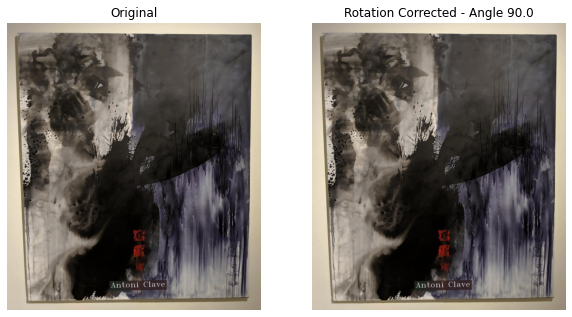

[[0.9495668564358084, [[298, 188], [660, 170], [672, 608], [310, 614]]]] 89.365 0.9495668564358084 89.6852


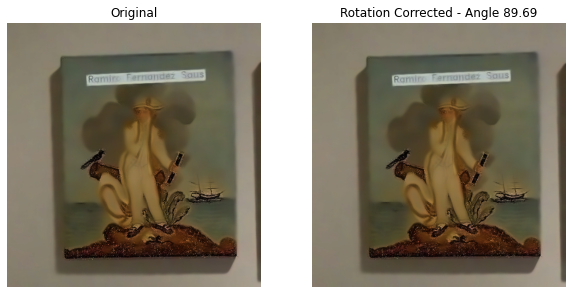

[[0.8092086141573418, [[2220, 652], [3660, 632], [3660, 2652], [2244, 2672]]]] 89.909 0.8092086141573418 89.28142


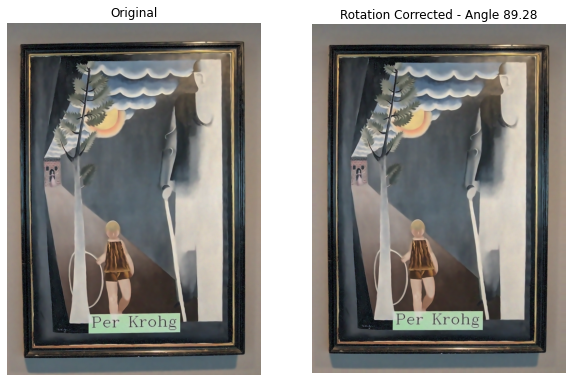

In [10]:
for idx, (img, filename) in enumerate(zip(qsd1_w5[:3], qsd1_w5_files[:3])):
    
    new_img, angle, rot_angle = rotate_image(img, plot=False)
    error = angular_error(frames[idx][0][0], angle)
    
    print (frames[idx], np.round(error,3), frames[idx][0][0], angle )
        
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(img)
    axarr[0].title.set_text("Original")
    axarr[0].axis('off')
    
    axarr[1].imshow(new_img, cmap="gray")
    axarr[1].title.set_text(f"Rotation Corrected - Angle {np.round(angle,2)}")
    axarr[1].axis('off')
    plt.show()

In [11]:
def background_crop (files, gt_masks= True, save_masks = False, plot_results=True, plot_rect=False):
    
    SCORES      = []
    PREDICTIONS = {}
    RESULT      = []
    FILENAMES   = []
    ANGLES      = []
    ROT_ERROR   = []

    for idx, file in enumerate(files):

        base_original = readimg (file)
        base, angle, rot_angle = rotate_image(base_original, plot=False)
        
        if gt_masks:
            rotation_error = [angular_error (frames[idx][0][0], angle) , angular_error (frames[idx][0][0], rot_angle)]
            rotation_error = np.min(rotation_error)
            if plot_results: print (rotation_error)
        else:
            rotation_error = 1
            
        
        if rotation_error < 20: # we consider error>20 outlier
            ROT_ERROR.append(rotation_error)

        if gt_masks:
            gt_mask = readimg (file.replace('.jpg', '.png'))

        base_rgb = base.copy()
        rgb = base.copy()
        
        base = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
        gray = base.copy()

        # Performing OTSU threshold
        
        _, base = cv2.threshold(base, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
        kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
        base = cv2.filter2D(base, -1, kernel)
        
        if base.shape[1]/base.shape[0] > 1.55: 
            # landscape images = multiple pictures
            _, base_inv = cv2.threshold(base, 0, 255, cv2.THRESH_OTSU)
            base_inv = cv2.filter2D(base_inv, -1, kernel)
            #print (base.shape[1]/base.shape[0], base.shape)            
            
        #base = cv2.Canny(base,100,200)
        
        # Morphology mask
        mask = base
        
        # opening 1) correct noise
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
        
        # closing 1) get shapes
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11)), iterations = 1)
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11)), iterations = 1)
        # closing 2) get shapes
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
        
        # opening -> closing define better edges
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 1)
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 1)
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 1)
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 1)
        
        mask = cv2.filter2D(mask, -1, kernel)
        mask = ((mask - 255)*(-1)).astype(np.uint8)
        
        #if base.shape[1]/base.shape[0] > 1.55: 
            #print (mask.dtype, mask.min(), mask.max())
            #mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13)), iterations = 1)
            #mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13)), iterations = 1)
        
        # Finding contours
        
        contours_mask, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours_base, _ = cv2.findContours(base, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = contours_mask + contours_base
        assert len(contours) == len(contours_base)+len(contours_mask)
            
        if base.shape[1]/base.shape[0] > 1.55: 
            contours_base_inv, _ = cv2.findContours(base_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = contours_mask + contours_base + contours_base_inv
           
        boxes = []
        areas = []
        
        for cnt in contours:
            
            x, y, w, h = cv2.boundingRect(cnt)
            cropped = base_rgb[y:y + h, x:x + w]
            area_cropped = cropped.shape[0] * cropped.shape[1]
            
            cond1 = (cropped.shape[1] >= int(rgb.shape[1]*0.9)) and (cropped.shape[0] <= int(rgb.shape[0]*0.25))
            cond2 = (base.shape[1]/base.shape[0] > 1.55)
            cond3 = cond2 and ((cropped.shape[0]*cropped.shape[1]) >= 0.9 * (rgb.shape[0]*rgb.shape[1]))
            cond4 = (cropped.shape[1]/cropped.shape[0]) > 13
            
            if (area_cropped <= 200*200) or (cropped.shape[0] < 200) or (cropped.shape[1] < 200) or cond3 or cond4: 
                continue
            elif cond1 and not(cond2):
                aux_box = (0, 0, 0 + rgb.shape[1], 0 + rgb.shape[0])
                cropped = base_rgb[0:0 + rgb.shape[1], 0:0 + rgb.shape[0]]
                area_cropped = cropped.shape[0] * cropped.shape[1]
                #print (1111, cropped.shape[1]/cropped.shape[0],  cropped.shape[1],cropped.shape[0])
                boxes.append(aux_box)
                areas.append((area_cropped, aux_box))
                
            else: 
                boxes.append((x, y, x + w, y + h))
                #print (1111, cropped.shape[1]/cropped.shape[0],  cropped.shape[1],cropped.shape[0])
                areas.append((area_cropped, (x, y, x + w, y + h)))
                #areas[area_cropped] = (x, y, x + w, y + h)
        
        
        if not(cond2): 
            boxes = NMS(np.array(boxes), overlapThresh = 0.5)

        # Produce mask
        morph_mask = mask.copy()
        mask = np.zeros(base_rgb.shape)
        
        contours_detect = len(boxes)
        #print ('contours detected:', len(boxes))
        
        if contours_detect > 20:
            # outlier due to weird texture images
            contours_detect = 1
            x, y, x2, y2 = (0, 0, 0 + rgb.shape[1], 0 + rgb.shape[0])
            cropped = base_rgb[y:y2, x:x2]
            mask [y:y2, x:x2] = 1
            if plot_rect:
                rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 10)
                
            PREDICTIONS[file] = boxes[0]
            RESULT.append(cropped)
            FILENAMES.append(file)
            
        elif contours_detect > 1:
            # 3 biggest boxes
            
            # remove possible duplicates in the lists
            areas = list(set(areas))
            #assert len(areas) == contours_detect
            #print (areas)
            #print ([x[0] for x in areas])
            #big = areas.sort(key=lambda x:x[0])
            areas = sorted(areas, key=lambda tup: tup[0], reverse=True)
            
            if len(areas) == 1:
                box1   = areas[0][1]
                nboxes = [box1]
            else:
                box1   = areas[0][1]
                box2   = areas[1][1]
                nboxes = [box1, box2]
                if len(areas) > 2:
                    box3   = areas[2][1]
                    nboxes = [box1, box2, box3]
            
            contours_detect = len(nboxes)
            
            PREDICTIONS[file] = nboxes
            for box in nboxes:
                x, y, x2, y2 = box
                cropped = base_rgb[y:y2, x:x2]
                mask [y:y2, x:x2] = 1
                if plot_rect:
                    rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 10)
                    
                #plt.imshow(cropped)
                #plt.axis('off')
                #plt.show()
                RESULT.append(cropped)
                FILENAMES.append(file)
                
        elif contours_detect == 1:
            
            x, y, x2, y2 = boxes[0]
            cropped = base_rgb[y:y2, x:x2]
            mask [y:y2, x:x2] = 1
            #print (x, y, x2, y2)
            if plot_rect:
                rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 10)
                
            PREDICTIONS[file] = boxes[0]
            RESULT.append(cropped)
            FILENAMES.append(file)
            #plt.imshow(rect)
            #plt.axis('off')
            #plt.show()
            #plt.imshow(cropped)
            #plt.axis('off')
            #plt.show()
            
        else:
            contours_detect = 1
            x, y, x2, y2 = (0, 0, 0 + rgb.shape[1], 0 + rgb.shape[0])
            cropped = base_rgb[y:y2, x:x2]
            mask [y:y2, x:x2] = 1
            #print (x, y, x2, y2)
            if plot_rect:
                rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 10)
                
            PREDICTIONS[file] = (0, 0, 0 + rgb.shape[1], 0 + rgb.shape[0])
            RESULT.append(cropped)
            FILENAMES.append(file)
            
            
        mask = mask.astype(np.uint8) * 255

        try:
            rot_gt_mask = ndimage.rotate(mask, rot_angle, mode='nearest')
            mask_iou = np.max([iou_score(gt_mask, mask) , iou_score(rot_gt_mask, mask)])
        except:
            mask_iou = 0.75
        
        SCORES.append(mask_iou)
        
        if plot_results:
            
            assert contours_detect <= 3
 
            f, axarr = plt.subplots(1,6, figsize=(15,15))
            axarr[0].imshow(base_original)
            axarr[0].title.set_text("Original")
            axarr[0].axis('off')
            axarr[1].imshow(rgb, cmap="gray")
            axarr[1].title.set_text("Rot. Corrected")
            axarr[1].axis('off')
            axarr[2].imshow(morph_mask, cmap="gray")
            axarr[2].title.set_text(f"Morphology Mask {contours_detect}")
            axarr[2].axis('off')
            axarr[3].imshow(mask, cmap="gray")
            axarr[3].title.set_text(f"Final Mask {np.round(mask_iou,2)} iou")
            axarr[3].axis('off')
            if gt_masks: 
                axarr[4].imshow(gt_mask, cmap="gray")
            else:
                axarr[4].imshow(mask, cmap="gray")
            axarr[4].title.set_text("GT Mask")
            axarr[4].axis('off')
            axarr[5].imshow(base_rgb)
            axarr[5].title.set_text("RGB")
            axarr[5].axis('off')
            plt.show()
    
    if gt_masks:
        print ('\n>> Mean IOU Score: ', np.mean(SCORES))
        print ('\n>> Mean Angle Error: ', np.mean(ROT_ERROR), np.median(ROT_ERROR))
        
    assert len(RESULT) == len(FILENAMES)
    return RESULT, FILENAMES

In [12]:
new_qsd1_w5, new_qsd1_w5_files = background_crop (files= qsd1_w5_files, gt_masks= True,  save_masks = False, plot_results=False, plot_rect=False)


>> Mean IOU Score:  0.875

>> Mean Angle Error:  0.7139929760224761 0.3985550861471552


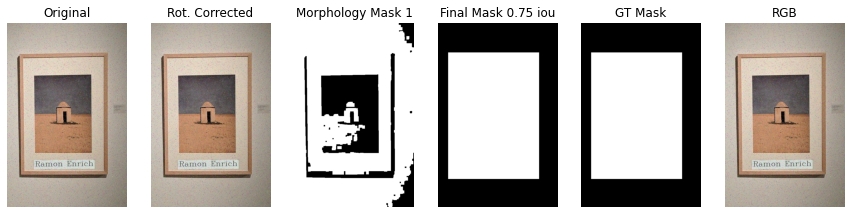

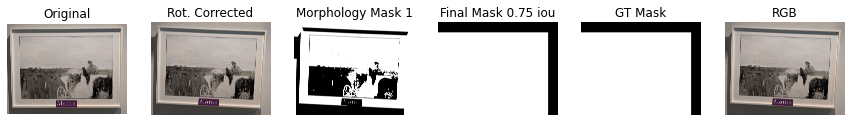

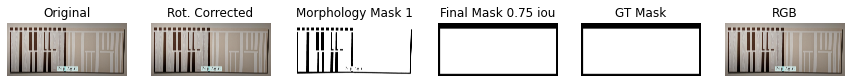

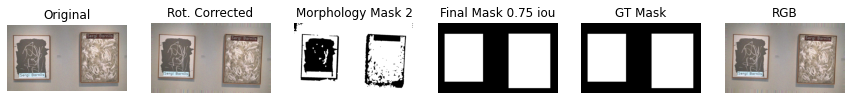

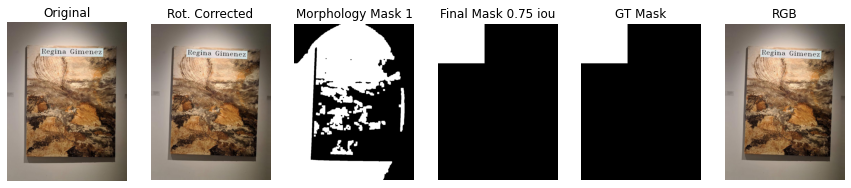

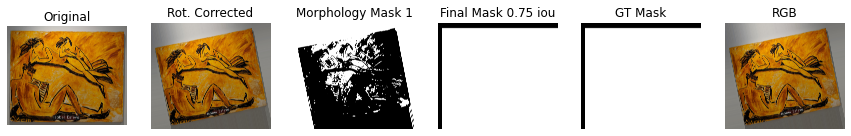

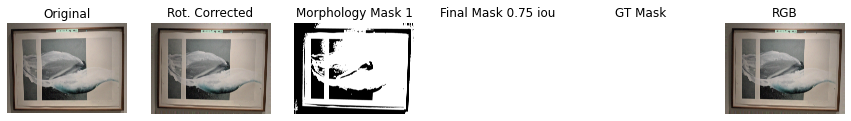

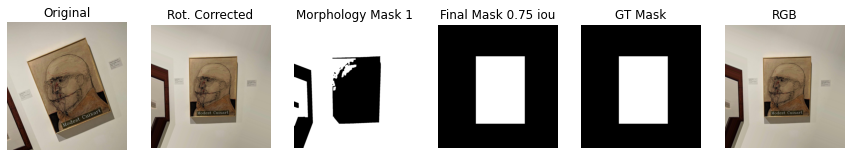

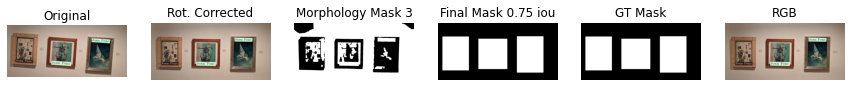

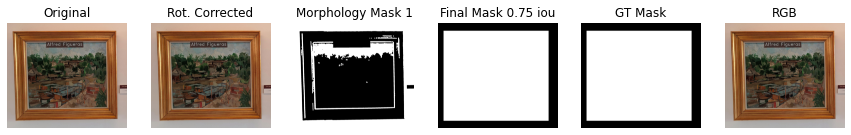

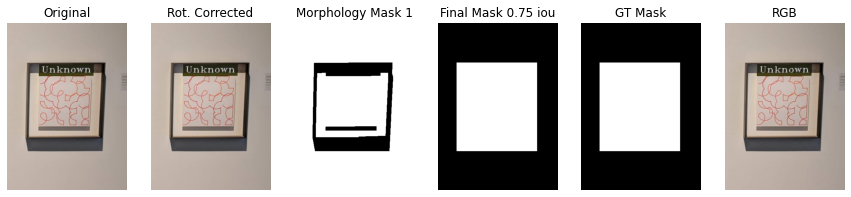

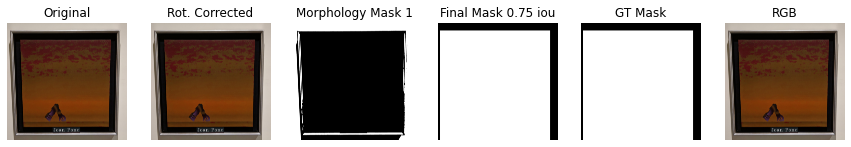

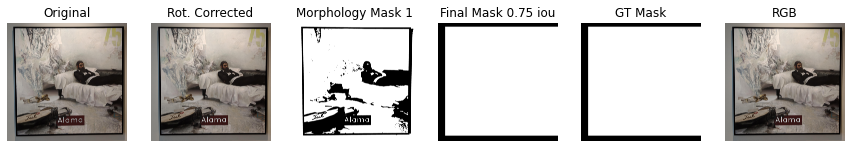

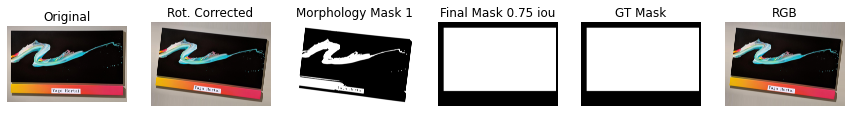

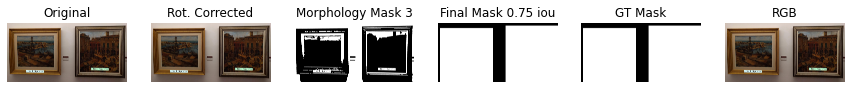

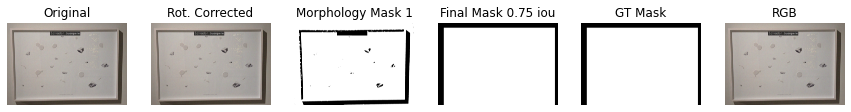

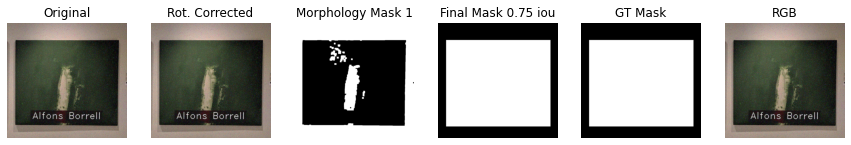

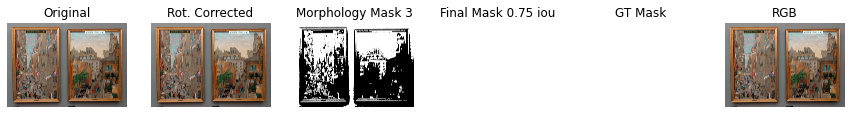

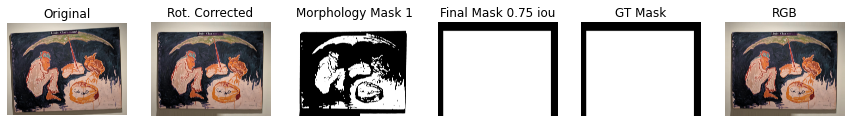

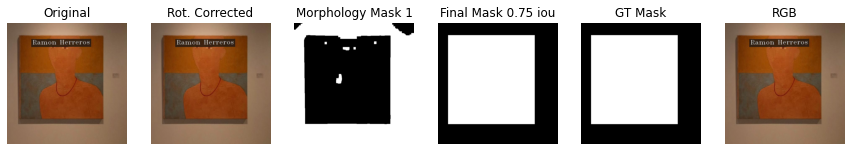

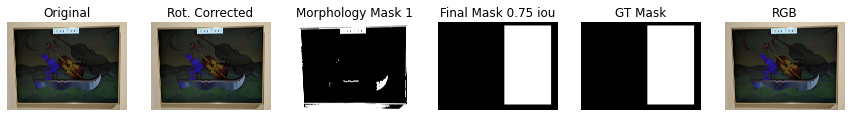

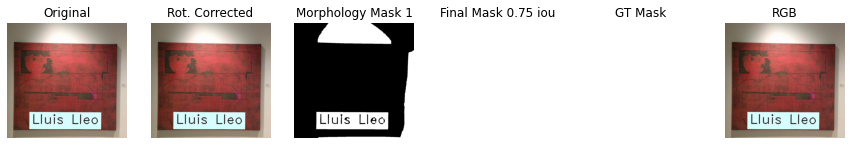

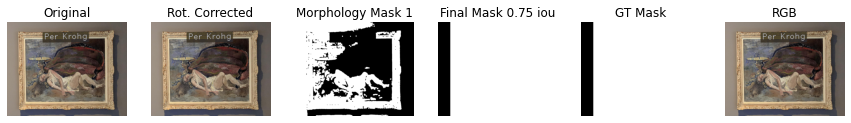

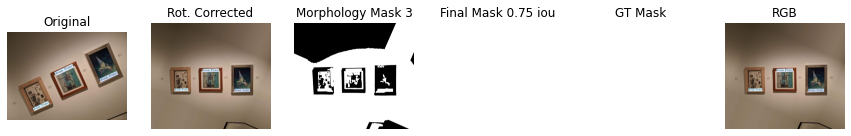

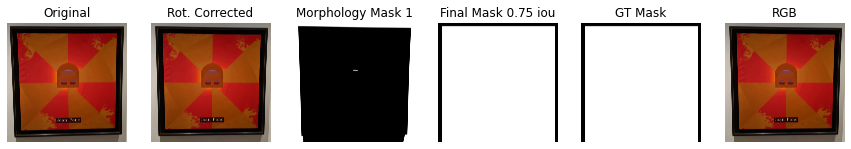

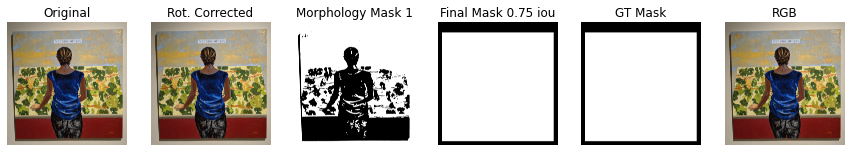

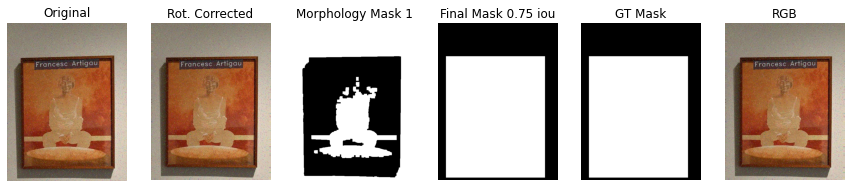

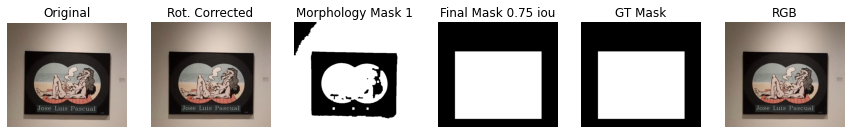

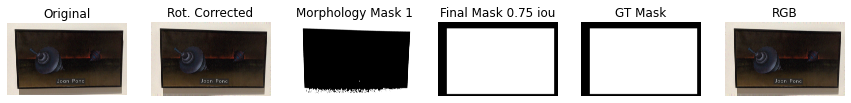

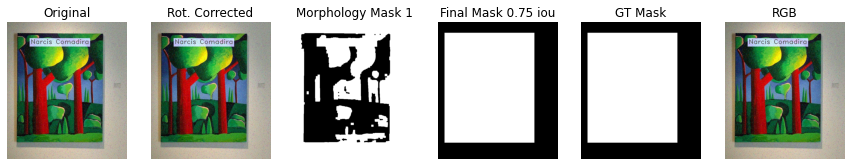

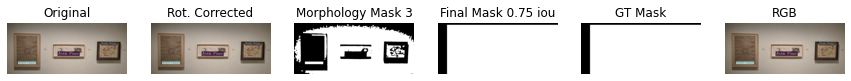

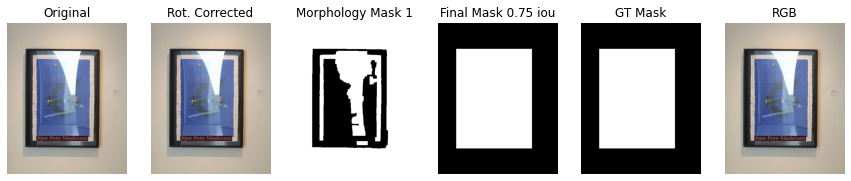

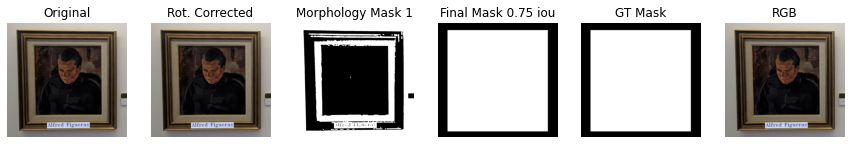

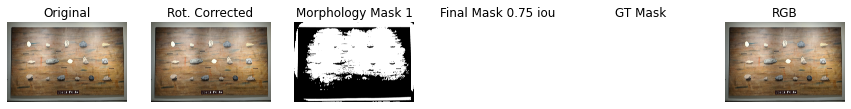

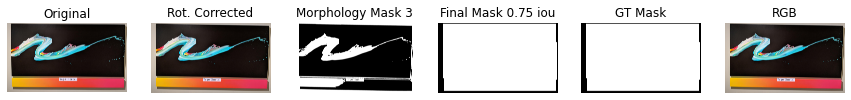

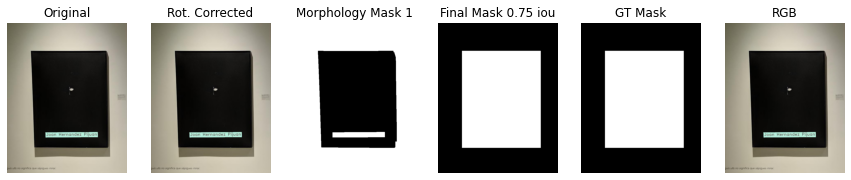

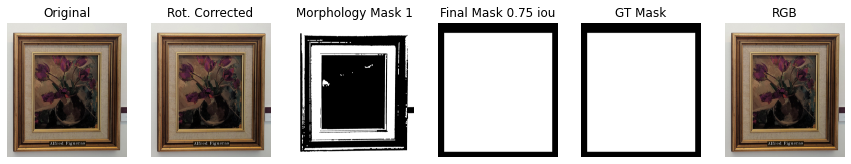

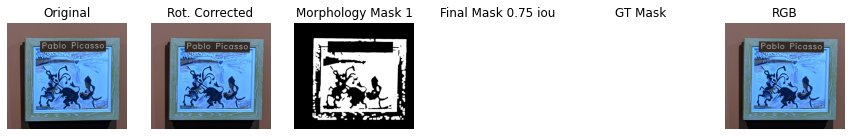

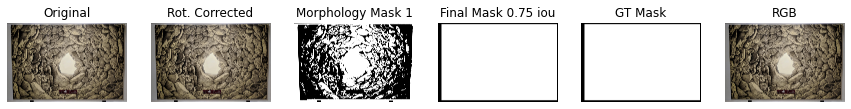

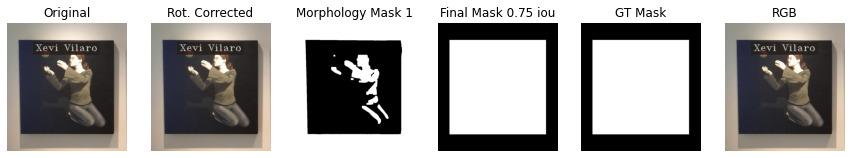

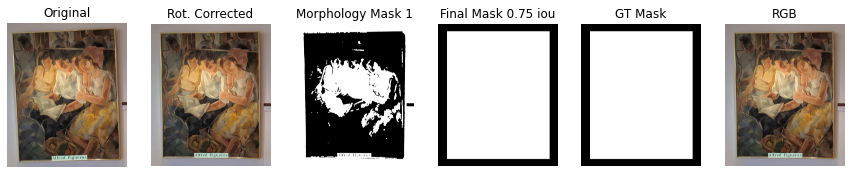

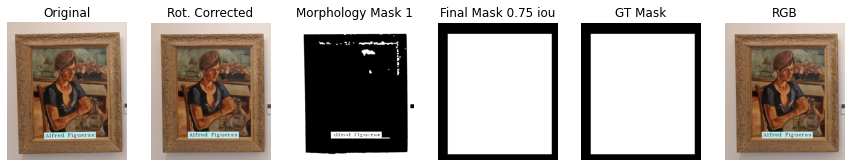

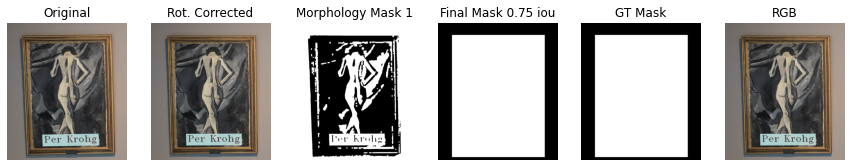

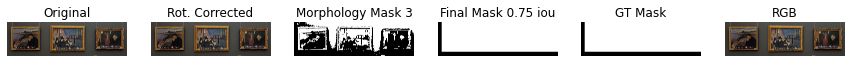

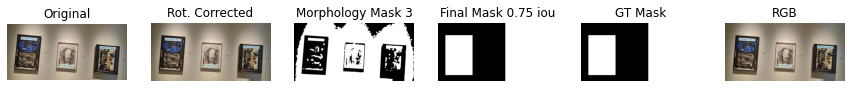

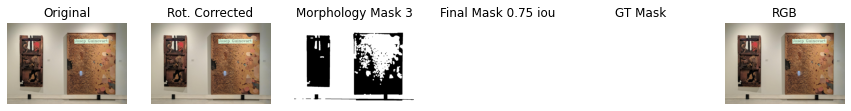

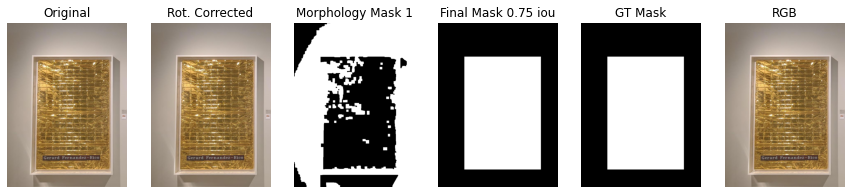

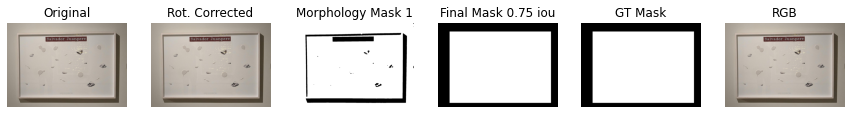

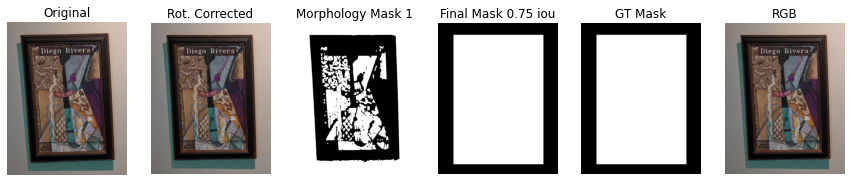

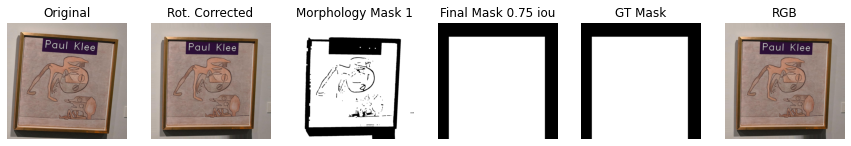

In [13]:
new_qst1_w5, new_qst1_w5_files = background_crop (files= qst1_w5_files, gt_masks= False,  save_masks = False, plot_results=True, plot_rect=False)

In [14]:
len(qsd1_w5), len(qsd1_w5_files), len(new_qsd1_w5) , len(new_qsd1_w5_files)

(30, 30, 42, 42)

In [15]:
len(qst1_w5), len(qst1_w5_files), len(new_qst1_w5) , len(new_qst1_w5_files)

(50, 50, 69, 69)

In [16]:
DO_BKGCROP = True

In [17]:
if DO_BKGCROP: 
    qsd1_w5, qsd1_w5_files = new_qsd1_w5, new_qsd1_w5_files
    qst1_w5, qst1_w5_files = new_qst1_w5, new_qst1_w5_files

In [18]:
# Crop-level Denoising

if DO_BKGCROP: 
    qsd1_w5 = denoise_images(qsd1_w5, method='median', ksize=(3,3))
    qst1_w5 = denoise_images(qst1_w5, method='median', ksize=(3,3))

100%|██████████| 69/69 [00:00<00:00, 334.66it/s]


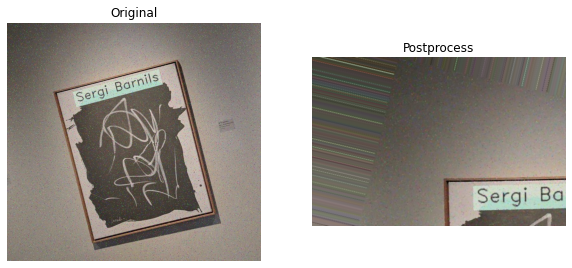

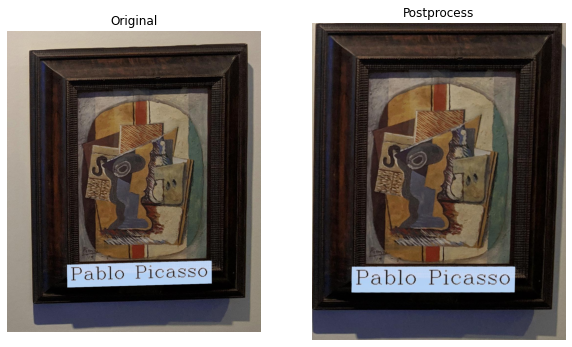

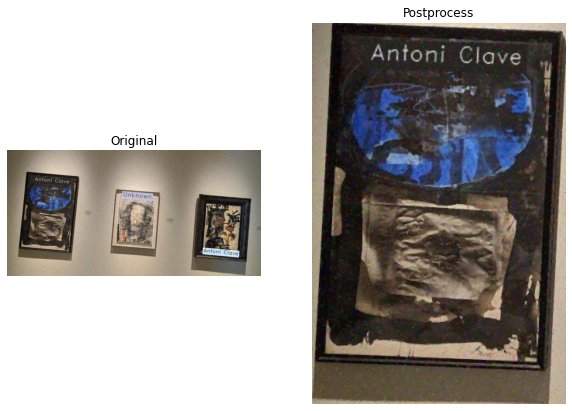

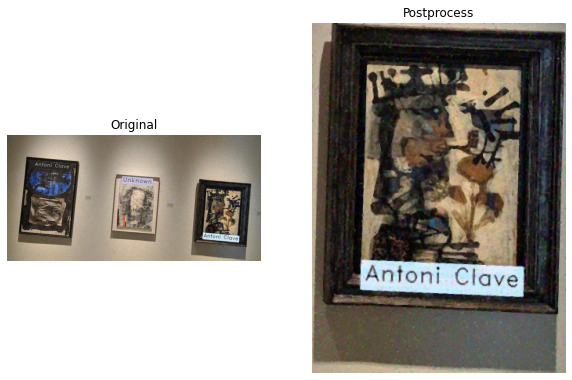

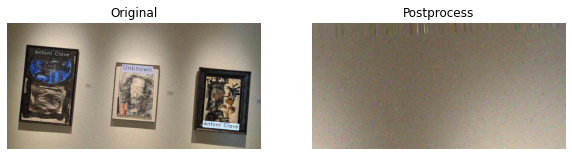

In [19]:
for idx, (img, filename) in enumerate(zip(qsd1_w5[10:15], qsd1_w5_files[10:15])):
    
    original = readimg(filename)
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(original)
    axarr[0].title.set_text("Original")
    axarr[0].axis('off')
    
    axarr[1].imshow(img, cmap="gray")
    axarr[1].title.set_text(f"Postprocess")
    axarr[1].axis('off')
    plt.show()

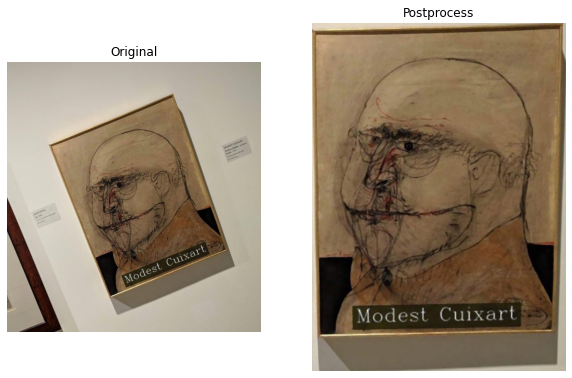

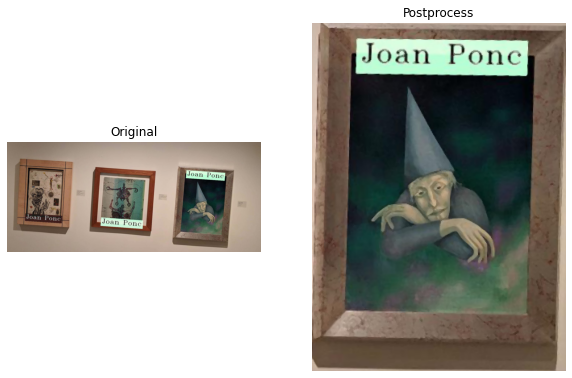

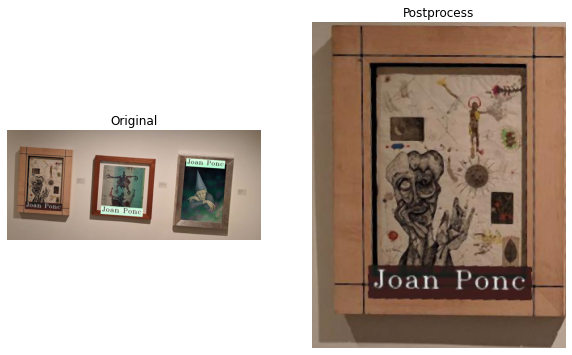

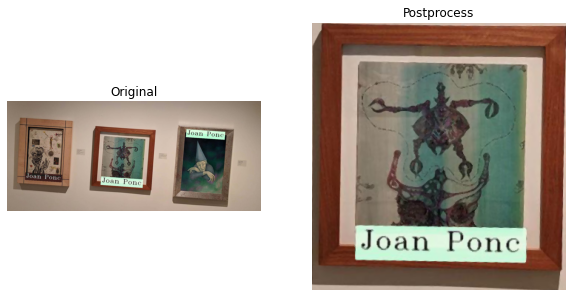

In [21]:
for idx, (img, filename) in enumerate(zip(qst1_w5[8:12], qst1_w5_files[8:12])):
    
    original = readimg(filename)
    f, axarr = plt.subplots(1,2, figsize=(10,10))
    axarr[0].imshow(original)
    axarr[0].title.set_text("Original")
    axarr[0].axis('off')
    
    axarr[1].imshow(img, cmap="gray")
    axarr[1].title.set_text(f"Postprocess")
    axarr[1].axis('off')
    plt.show()

## Step 2) Text Removal using crops

In [22]:
DO_TEXT_REMOVAL = False

In [23]:
#Method to remove text from the image with a rectangle 0 mask
if DO_TEXT_REMOVAL:
    qsd1_w5,contours = text_removal(qsd1_w5,num_images= 1, method='better', desc = 'Removing text of images') 

## Step 3) Feature extraction

In [24]:
NBINS = 16
NCOLS = 8
NROWS = 8
BLOCK = True

In [25]:
# 3D Normalized Histograms Multiresolutio/Block Images + Hog + SIFT
db_color_matrix = calculate_histograms(data = db, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc="Normalized 3D Histograms Calculation for BBDD...")
db_texture_matrix = calculate_hog(data = db, desc="Histogram of Gradient (HoG) for BBDD...")
keypoints_db, db_descriptor = calculate_sift(data = db, desc = "SIFT for BBDD...")
keypoints_db_orb, db_descriptor_orb = calculate_orb(data = db, desc = "ORB for BBDD...")

qsd1_w5_color_matrix = calculate_histograms(data = qsd1_w5, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qsd1_w5...")
qsd1_w5_texture_matrix = calculate_hog(data = qsd1_w5, desc = "Histogram of Gradient (HoG) for qsd1_w5...")
keypoints_qsd1_w5, qsd1_w5_local_matrix = calculate_sift(data = qsd1_w5, desc = "SIFT for qsd1_w5...")
keypoints_qsd1_w5_orb, qsd1_w5_local_matrix_orb = calculate_orb(data = qsd1_w5, desc = "ORB for BBDD...")

# Test
qst1_w5_color_matrix = calculate_histograms(data = qst1_w5, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qsd1_w5...")
qst1_w5_texture_matrix = calculate_hog(data = qst1_w5, desc = "Histogram of Gradient (HoG) for qsd1_w5...")
keypoints_qst1_w5, qst1_w5_local_matrix = calculate_sift(data = qst1_w5, desc = "SIFT for qsd1_w5...")
keypoints_qst1_w5_orb, qst1_w5_local_matrix_orb = calculate_orb(data = qst1_w5, desc = "ORB for BBDD...")

SIFT for BBDD...: 100%|██████████| 287/287 [01:08<00:00,  4.19it/s]
d:\Documentos\Team8\utils\image_processing.py:425: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return keypoints, np.array(descriptors)
ORB for BBDD...: 100%|██████████| 287/287 [00:58<00:00,  4.87it/s]
d:\Documentos\Team8\utils\image_processing.py:410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return keypoints, np.array(descriptors)
Normalized 3D Histograms Calculation for qsd1_w5...: 100%|██████████| 42/42 [00:00<00:00, 128.72it/s]
ORB for BBDD...: 100%|██████████| 42/42 [00:0

In [26]:
# Similarity
sim = Similarity()
qsd1_w5_similarities_color      = sim.compute_similarities(qs = qsd1_w5_color_matrix, db_feature_matrix = db_color_matrix, desc = "Computing qsd1_w5 similarities...", similarity = 'hellinger')
qsd1_w5_similarities_texture    = sim.compute_similarities(qs = qsd1_w5_texture_matrix, db_feature_matrix = db_texture_matrix, desc = "Computing qsd1_w5 similarities...", similarity = 'hellinger')
qsd1_w5_similarities_local      = sim.compute_similarities(qs = qsd1_w5_local_matrix, db_feature_matrix = db_descriptor, desc = "Computing qsd1_w5 similarities...", similarity = 'local')
qsd1_w5_similarities_local_orb  = sim.compute_similarities(qs = qsd1_w5_local_matrix_orb, db_feature_matrix = db_descriptor_orb, desc = "Computing qsd1_w5 similarities...", similarity = 'local')

Computing qsd1_w5 similarities...: 100%|██████████| 42/42 [00:00<00:00, 95.37it/s]


In [27]:
qst1_w5_similarities_color      = sim.compute_similarities(qs = qst1_w5_color_matrix, db_feature_matrix = db_color_matrix, desc = "Computing qst1_w5 similarities...", similarity = 'hellinger')
qst1_w5_similarities_texture    = sim.compute_similarities(qs = qst1_w5_texture_matrix, db_feature_matrix = db_texture_matrix, desc = "Computing qst1_w5 similarities...", similarity = 'hellinger')
qst1_w5_similarities_local      = sim.compute_similarities(qs = qst1_w5_local_matrix, db_feature_matrix = db_descriptor, desc = "Computing qst1_w5 similarities...", similarity = 'local')
qst1_w5_similarities_local_orb  = sim.compute_similarities(qs = qst1_w5_local_matrix_orb, db_feature_matrix = db_descriptor_orb, desc = "Computing qst1_w5 similarities...", similarity = 'local')

Computing qst1_w5 similarities...: 100%|██████████| 69/69 [00:00<00:00, 95.48it/s]


In [28]:
alpha = 0.3
beta  = 0.7

qsd1_w5_sim_combine   = qsd1_w5_similarities_color*alpha + qsd1_w5_similarities_texture*beta
qsd1_w5_sim_combine_2 = qsd1_w5_similarities_texture*alpha + qsd1_w5_similarities_local*beta
qsd1_w5_sim_combine_3 = qsd1_w5_similarities_local_orb*alpha + qsd1_w5_similarities_local*beta
qsd1_w5_sim_combine_4 = qsd1_w5_sim_combine*alpha + qsd1_w5_similarities_local*beta

In [29]:
## Check similarities
qst1_w5_similarities_local[0][:5], qst1_w5_similarities_local_orb[0][:5]

(array([0.01339319, 0.        , 0.04974612, 0.06313931, 0.02487306]),
 array([0, 0, 0, 0, 0]))

### Validation Scores

In [32]:
DESCRIPTORS = {
    'color + texture':qsd1_w5_sim_combine,
    'SIFT': qsd1_w5_similarities_local,
    'ORB': qsd1_w5_similarities_local_orb,
    'ORB + SIFT': qsd1_w5_sim_combine_3,
    'SIFT + color + texture': qsd1_w5_sim_combine_2
}

In [34]:
SAVE_RESULTS = False

results = {
    'color + texture': {1: [], 5: []},
    'SIFT': {1: [], 5: []},
    'ORB': {1: [], 5: []},
    'ORB + SIFT': {1: [], 5: []},
    'SIFT + color + texture': {1: [], 5: []}
}

for des in DESCRIPTORS.keys():
    for th in np.arange(0.01, 1.01, 0.01):
        for K in [1, 5]:
            s = DESCRIPTORS[des]
            res = sim.get_top_k(similarity_matrix = s, db_files = db_files, k=K ,th=th, desc="Retrieving qsd1_w5 top K similar images...", progress = False)
            predicted_results = data_manager.save_results_1(results = res, path = "./week5/QSD1/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
            predicted_results = data_manager.fix_multi_image(results = predicted_results, results_files = qsd1_w5_files)
            expected_results = pickle.load(file = open('./data/qsd1_w5/gt_corresps.pkl', "rb"))
            metric = metrics.mapk(actual = expected_results, predicted = predicted_results, k=K)
            msg = "{}: QSD1-W4 MAP@{} (th: {:.2f}) Score: {:.4f} ({}/{})".format(des, K,th,metric,int(len(predicted_results)*metric),len(predicted_results))
            results[des][K].append((metric, msg, predicted_results))


good = {}
for des in results.keys():
    for K in results[des].keys():
        best = max(results[des][K])
        print(best[1])
        good[des] = {K: None}
        good[des][K] = best

color + texture: QSD1-W4 MAP@1 (th: 0.62) Score: 0.5000 (15/30)
color + texture: QSD1-W4 MAP@5 (th: 0.62) Score: 0.4778 (14/30)
SIFT: QSD1-W4 MAP@1 (th: 0.29) Score: 0.7333 (22/30)
SIFT: QSD1-W4 MAP@5 (th: 0.29) Score: 0.7130 (21/30)
ORB: QSD1-W4 MAP@1 (th: 1.00) Score: 0.3333 (10/30)
ORB: QSD1-W4 MAP@5 (th: 1.00) Score: 0.3333 (10/30)
ORB + SIFT: QSD1-W4 MAP@1 (th: 0.19) Score: 0.7333 (22/30)
ORB + SIFT: QSD1-W4 MAP@5 (th: 0.19) Score: 0.7130 (21/30)
SIFT + color + texture: QSD1-W4 MAP@1 (th: 0.38) Score: 0.7333 (22/30)
SIFT + color + texture: QSD1-W4 MAP@5 (th: 0.38) Score: 0.7296 (21/30)


In [ ]:
from skimage.transform import resize

def plot_matches(results, qs, db, kp_qs, desc_qs, kp_db, desc_db):
    for i,idx in enumerate(results):
        idx = idx[0]
        if idx != -1:
            # Query image
            im1 = resize(image = qs[i], output_shape=(500,500))
            im1 = rgb2gray(im1)*255
            im1 = im1.astype(np.uint8)
            kp1, desc1 = kp_qs[i], desc_qs[i]


            # DB image
            im2 = resize(image = db[idx], output_shape=(500,500))
            im2 = rgb2gray(im2)*255
            im2 = im2.astype(np.uint8)
            kp2, desc2 = kp_db[idx], desc_db[idx]

            bf = cv2.BFMatcher_create(cv2.NORM_HAMMING,crossCheck=True)
            matches = bf.match(desc1, desc2)
            matches = sorted(matches,key=lambda x:x.distance)

            im_matches = cv2.drawMatches(im1, kp1, im2, kp2, matches, None, flags=2)
            plt.figure(figsize = (20,20))
            plt.imshow(im_matches)
            plt.show()
            
#plot_matches(predicted_results, qsd1_w5, db, keypoints_qsd1_w5_orb, qsd1_w5_local_matrix_orb, keypoints_db_orb, db_descriptor_orb)

# Submission

In [50]:
top_k_qst1_w5_local = sim.get_top_k(similarity_matrix = qst1_w5_similarities_local, db_files = db_files, k=10 ,th=0.29, desc="Retrieving qst1_w5 top K similar images...", progress = False)
predicted_results = data_manager.save_results_1(results = top_k_qst1_w5_local, path = "./week5/QST1/method1", save = True) # FOR QS WITH 1 PAINTING
#predicted_results = data_manager.fix_multi_image(results = predicted_results, results_files = qsd1_w5_files)

FIX = False

with open('./week5/QST1/method1/result.pkl', 'rb') as f:
    data = pickle.load(f)
    
if FIX:
    output = open('./week5/QST1/method1/result.pkl', 'wb')
    pickle.dump(data, output)
    output.close()

    with open('./week5/QST1/method1/result.pkl', 'rb') as f:
        data = pickle.load(f)
        data = [list(pred) for pred in data]

RESULTS = {}

# initialize dictionary
for file in qst1_w5_files:
    RESULTS[file] = []


def get_id(file):
    try:
        return file.replace('./data/BBDD/bbdd_', '').replace('.jpg', '')
    except:
        return -1
    
for file, results in zip(qst1_w5_files,top_k_qst1_w5_local):
    results = [get_id(result) for result in results]
    results = [int(result) for result in results]
    RESULTS[file].append(results)

# add extra [] to single results
for file in qst1_w5_files:
    if len(RESULTS[file]) == 1:
        RESULTS[file].append([-1])
    if len(RESULTS[file]) == 2:
        RESULTS[file].append([-1])
        
# final check       
for file in qst1_w5_files:
    assert len(RESULTS[file]) == 3
    
RESULTS = list(RESULTS.values())

output = open('./week5/QST1/method1/result.pkl', 'wb')
pickle.dump(RESULTS, output)
output.close()



FIX = False

with open('./week5/QST1/method1/result.pkl', 'rb') as f:
    data = pickle.load(f)
    
if FIX:
    output = open('./week5/QST1/method1/result.pkl', 'wb')
    pickle.dump(data, output)
    output.close()

    with open('./week5/QST1/method1/result.pkl', 'rb') as f:
        data = pickle.load(f)
        data = [list(pred) for pred in data]

Results Saved!


In [51]:
for row in range(len(data)):
    r = data[row]
    for image in range(len(r)):
        if r[image][0] == -1 and len(r[image]) > 1:
            data[row][image] = [-1]
            
output = open('./week5/QST1/method1/result.pkl', 'wb')
pickle.dump(data, output)
output.close()

In [66]:
data

[[[-1], [-1], [-1]],
 [[18, 128, 24, 44, 102, 75, 67, 204, 165, 19], [-1], [-1]],
 [[-1], [-1], [-1]],
 [[35, 128, 25, 66, 231, 89, 100, 248, 184, 163],
  [258, 13, 45, 80, 263, 171, 39, 186, 261, 183],
  [-1]],
 [[-1], [-1], [-1]],
 [[128, 163, 66, 129, 243, 25, 158, 89, 188, 98], [-1], [-1]],
 [[-1], [-1], [-1]],
 [[22, 129, 158, 89, 148, 138, 188, 211, 195, 75], [-1], [-1]],
 [[262, 184, 269, 195, 193, 105, 110, 92, 192, 13],
  [90, 243, 271, 163, 105, 192, 113, 19, 246, 47],
  [91, 186, 204, 171, 38, 129, 269, 89, 124, 25]],
 [[215, 186, 246, 105, 124, 243, 175, 89, 38, 100], [-1], [-1]],
 [[189, 148, 254, 75, 89, 273, 158, 129, 229, 17], [-1], [-1]],
 [[-1], [-1], [-1]],
 [[-1], [-1], [-1]],
 [[-1], [-1], [-1]],
 [[259, 186, 89, 171, 124, 247, 31, 270, 43, 97],
  [192, 175, 31, 240, 172, 239, 178, 8, 89, 47],
  [259, 207, 92, 209, 269, 25, 103, 33, 270, 175]],
 [[-1], [-1], [-1]],
 [[-1], [-1], [-1]],
 [[-1],
  [193, 100, 140, 240, 113, 175, 285, 246, 195, 31],
  [161, 186, 246, 2